In [52]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import scipy.sparse as sp

In [78]:
Cora = Planetoid(root='/tmp/Cora', name='Cora')
Pubmed = Planetoid(root='/tmp/Pubmed', name='Pubmed')
Citeseer = Planetoid(root='/tmp/Citeseer', name='Citeseer')

In [122]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features = 256):
        super(GCN, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.PRelu = nn.PReLU() 
        
        nn.init.xavier_uniform_(self.linear.weight.data)
        
    def forward(self, x, a):
        xtheta = self.linear(x)
        output = torch.unsqueeze(torch.spmm(a, torch.squeeze(xtheta, 0)), 0)
        output = self.PRelu(output)
        
        return output 
    
class Discriminator(nn.Module):
    def __init__(self, in1_features, in2_features, out_features):
        super(Discriminator, self).__init__()
        self.linear = nn.Bilinear(in1_features, in2_features, out_features)
        # self.logsigmoid = nn.LogSigmoid()
        
        nn.init.xavier_uniform_(self.linear.weight.data)
        
    def forward(self, hi, s):
        
        hiWs = self.linear(hi, s)
        # output = self.logsigmoid(hiWs)
        
        return hiWs
    
class Readout(nn.Module):
    def __init__(self):
        super(Readout, self).__init__()
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, H):
        output = torch.mean(H, 1)
        # output = self.logsigmoid(output)
        
        return output

In [123]:
class DGI(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(DGI, self).__init__()
        self.GCN = GCN(in_features, hidden_dim)
        self.Discriminator = Discriminator(hidden_dim, hidden_dim, 1)
        self.Readout = Readout()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, pos, neg, a):
        pos_H = self.GCN(pos, a)
        neg_H = self.GCN(neg, a)
        
        s = self.Readout(pos_H)
        s = self.Sigmoid(s) 
        s = torch.unsqueeze(s, 1).expand_as(pos_H)
        
        pos_score = self.Discriminator(pos_H, s).squeeze(2)
        neg_score = self.Discriminator(neg_H, s).squeeze(2) 
        logits = torch.cat((pos_score, neg_score), dim=1)
        
        return logits
    
    def get_embedding(self, x, a):
        return self.GCN(x, a)

In [104]:
class GCN(nn.Module):
    def __init__(self, in_ft, out_ft, act, bias=True):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft, bias=False)
        self.act = nn.PReLU() if act == 'prelu' else act
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_ft))
            self.bias.data.fill_(0.0)
        else:
            self.register_parameter('bias', None)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    # Shape of seq: (batch, nodes, features)
    def forward(self, seq, adj, sparse=False):
        seq_fts = self.fc(seq)
        if sparse:
            out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(seq_fts, 0)), 0)
        else:
            out = torch.bmm(adj, seq_fts)
        if self.bias is not None:
            out += self.bias
        
        return self.act(out)
    
class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = torch.unsqueeze(c, 1)
        c_x = c_x.expand_as(h_pl)

        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 2)
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 2)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, seq, msk):
        if msk is None:
            return torch.mean(seq, 1)
        else:
            msk = torch.unsqueeze(msk, -1)
            return torch.sum(seq * msk, 1) / torch.sum(msk)

class DGI(nn.Module):
    def __init__(self, n_in, n_h, activation):
        super(DGI, self).__init__()
        self.gcn = GCN(n_in, n_h, activation)
        self.read = AvgReadout()

        self.sigm = nn.Sigmoid()

        self.disc = Discriminator(n_h)

    def forward(self, seq1, seq2, adj, sparse, msk, samp_bias1, samp_bias2):
        h_1 = self.gcn(seq1, adj, sparse)

        c = self.read(h_1, msk)
        c = self.sigm(c)

        h_2 = self.gcn(seq2, adj, sparse)

        ret = self.disc(c, h_1, h_2, samp_bias1, samp_bias2)

        return ret

    # Detach the return variables
    def embed(self, seq, adj, sparse, msk):
        h_1 = self.gcn(seq, adj, sparse)
        c = self.read(h_1, msk)

        return h_1.detach(), c.detach()

In [124]:
Cora_Graph = Pubmed[0]

In [125]:
data = np.ones(Cora_Graph.edge_index.shape[1])

In [126]:
adj = csr_matrix((data,(Cora_Graph.edge_index[0].numpy(),Cora_Graph.edge_index[1].numpy())))

In [127]:
adj

<19717x19717 sparse matrix of type '<class 'numpy.float64'>'
	with 88648 stored elements in Compressed Sparse Row format>

In [128]:
adj = sp.coo_matrix(adj)
rowsum = np.array(adj.sum(1))
d_inv_sqrt = np.power(rowsum, -0.5).flatten()
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
adj

<19717x19717 sparse matrix of type '<class 'numpy.float64'>'
	with 88648 stored elements in COOrdinate format>

In [129]:
adj = adj + sp.eye(adj.shape[0])

In [130]:
def sparse_mx_to_torch(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [131]:
a_hat = sparse_mx_to_torch(adj)

In [132]:
a_hat

tensor(indices=tensor([[    0,  1378,  1544,  ..., 19715, 16030, 19716],
                       [    0,     0,     0,  ..., 19715, 19716, 19716]]),
       values=tensor([1.0000, 0.0745, 0.0756,  ..., 1.0000, 0.3780, 1.0000]),
       size=(19717, 19717), nnz=108365, layout=torch.sparse_coo)

In [133]:
a_hat.size()


torch.Size([19717, 19717])

In [134]:
Cora_Graph.x.size()

torch.Size([19717, 500])

In [135]:
feature = Cora_Graph.x.numpy()
rowsum = np.sum(feature, axis=1)
rowsum_diag = np.diag(rowsum)
rowsum_inv = np.power(rowsum_diag, -1)
rowsum_inv[np.isinf(rowsum_inv)] = 0.0
x_feature = np.dot(rowsum_inv, feature)

/tmp/ipykernel_29184/4175734885.py:4: RuntimeWarning: divide by zero encountered in power
  rowsum_inv = np.power(rowsum_diag, -1)


In [136]:
x_feature = torch.FloatTensor(x_feature[np.newaxis])

In [137]:
x_feature.size()[1]

19717

In [138]:
model = DGI(x_feature.size()[2], 512)

In [42]:
model = DGI(x_feature.size()[2], 256, 'prelu')

TypeError: DGI.__init__() takes 3 positional arguments but 4 were given

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [44]:
cur_loss = 100000
count = 0
max_count = 10
loss_list = [] 

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    pos_lb = torch.ones(1, 2708)
    neg_lb = torch.zeros(1, 2708)
    pos_neg_lb = torch.cat((pos_lb, neg_lb), dim=1)
    
    corrupted_node = np.random.permutation(2708)
    corrupted_features = x_feature[:, corrupted_node, :]
    # logit = model(x_feature, corrupted_features, a_hat, True, None, None, None)
    logit = model(x_feature, corrupted_features, a_hat)
    loss = criterion(logit, pos_neg_lb)
    
    if cur_loss > loss.item():
        cur_loss = loss.item()
        torch.save(model.state_dict(), 'best_dgi.pt')
    
    loss.backward()
    optimizer.step()
    
    print('Epoch: {:04d}'.format(epoch+1), 'loss: {:.4f}'.format(loss.item()))
    

Epoch: 0001 loss: 0.6932
Epoch: 0002 loss: 0.7211
Epoch: 0003 loss: 0.6928
Epoch: 0004 loss: 0.7022
Epoch: 0005 loss: 0.7062
Epoch: 0006 loss: 0.6993
Epoch: 0007 loss: 0.6936
Epoch: 0008 loss: 0.6921
Epoch: 0009 loss: 0.6932
Epoch: 0010 loss: 0.6945
Epoch: 0011 loss: 0.6947
Epoch: 0012 loss: 0.6938
Epoch: 0013 loss: 0.6925
Epoch: 0014 loss: 0.6915
Epoch: 0015 loss: 0.6914
Epoch: 0016 loss: 0.6918
Epoch: 0017 loss: 0.6915
Epoch: 0018 loss: 0.6906
Epoch: 0019 loss: 0.6893
Epoch: 0020 loss: 0.6884
Epoch: 0021 loss: 0.6876
Epoch: 0022 loss: 0.6869
Epoch: 0023 loss: 0.6862
Epoch: 0024 loss: 0.6848
Epoch: 0025 loss: 0.6833
Epoch: 0026 loss: 0.6819
Epoch: 0027 loss: 0.6804
Epoch: 0028 loss: 0.6785
Epoch: 0029 loss: 0.6764
Epoch: 0030 loss: 0.6747
Epoch: 0031 loss: 0.6717
Epoch: 0032 loss: 0.6696
Epoch: 0033 loss: 0.6657
Epoch: 0034 loss: 0.6621
Epoch: 0035 loss: 0.6585
Epoch: 0036 loss: 0.6548
Epoch: 0037 loss: 0.6500
Epoch: 0038 loss: 0.6456
Epoch: 0039 loss: 0.6408
Epoch: 0040 loss: 0.6356


In [45]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

        nn.init.xavier_uniform_(self.fc.weight.data)

    def forward(self, x):
        output = self.linear(x)
        return output

In [140]:
model.load_state_dict(torch.load('best_Pubmed.pt'))

embedding = model.get_embedding(x_feature, a_hat)


In [141]:
embedding.squeeze(0).size()

torch.Size([19717, 512])

In [142]:
Cora_Graph.y

tensor([1, 1, 0,  ..., 2, 0, 2])

In [143]:
embedding = embedding.squeeze(0).detach().numpy() 
label = Cora_Graph.y.numpy()

In [144]:
from sklearn.manifold import TSNE

In [145]:
TSNE_embedding = TSNE(n_components=2).fit_transform(embedding)


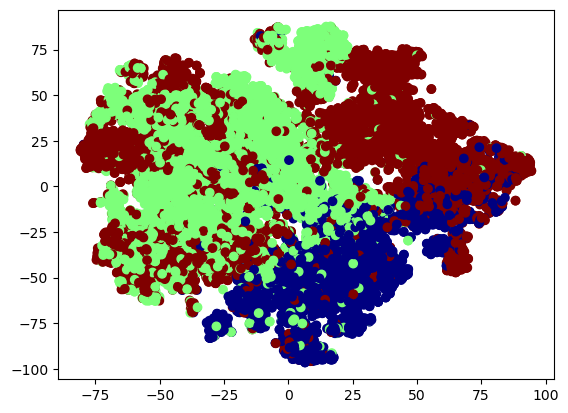

In [146]:
from matplotlib import pyplot as plt
plt.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1], c=label, cmap='jet')

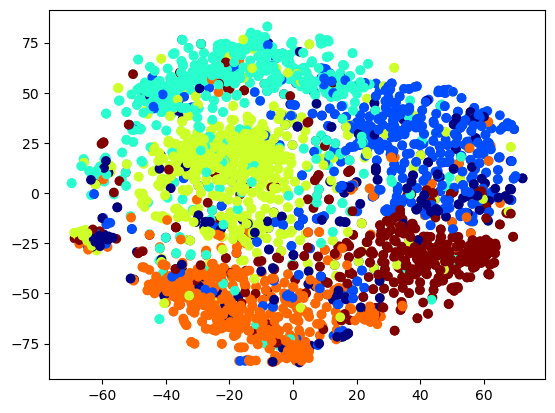

In [102]:
from matplotlib import pyplot as plt
plt.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1], c=label, cmap='jet')

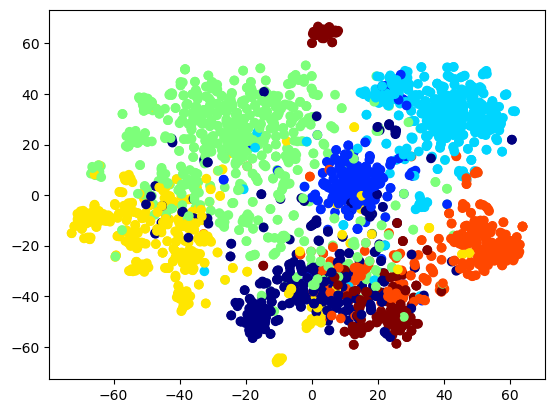

In [77]:
from matplotlib import pyplot as plt
plt.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1], c=label, cmap='jet')

In [57]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

train_x, test_x, train_y, test_y = train_test_split(embedding.squeeze(0).detach().numpy(), Cora_Graph.y.numpy(), test_size=0.2, random_state=42)

In [58]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_x, train_y)

In [64]:
from sklearn.metrics import accuracy_score, f1_score

In [62]:
pred = LR.predict(test_x)

In [65]:
accuracy_score(test_y, pred)

0.8228782287822878

In [66]:
f1_score(test_y, pred, average='micro')

0.8228782287822878

In [67]:
f1_score(test_y, pred, average='macro')

0.7646840704787722

## Inductive learning on large graphs

In [1]:
from torch_geometric.datasets import Reddit

In [10]:
Reddit_dataset = Reddit(root='/tmp/Reddit')

In [12]:
graph = Reddit_dataset[0]

In [13]:
from torch_geometric.nn import GraphSAGE

In [15]:
GraphSAGE()

TypeError: BasicGNN.__init__() missing 3 required positional arguments: 'in_channels', 'hidden_channels', and 'num_layers'

In [ ]:
dfdf